# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

## System setup

Udacity platform is not updated, so I have to do it by myself

In [1]:
# uncomment the row below if you unable to properly read JSON format
#!pip install --upgrade pandas
import pandas as pd
pd.__version__

'1.1.5'

## Import libraries and read data

In [2]:
import matplotlib.pyplot as plt
import re
import json
from pandas.io.json import json_normalize
import numpy as np
import math

% matplotlib inline

# read the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Transformation

### Portfolio transformation

In [3]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [4]:
# Split 'channels' to columns
portfolio['web'] = portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
portfolio['email'] = portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
portfolio['mobile'] = portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
portfolio['social'] = portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
portfolio = portfolio.drop(columns=['channels'])

# Rename 'id' to easily join it with portfolio data set
portfolio = portfolio.rename(columns={'id':'offer_id'})
portfolio

,reward,difficulty,duration,offer_type,offer_id,web,email,mobile,social
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0


In [5]:
# Split offer types to separate columns for ML
dummies = pd.get_dummies(portfolio['offer_type'])
portfolio = pd.concat([portfolio,dummies],axis=1)
portfolio

,reward,difficulty,duration,offer_type,offer_id,web,email,mobile,social,bogo,discount,informational
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1,0,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0,0,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,1,0,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,0,1,0
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,0,0,1
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0,0,1,0


### Profile transformation

In [6]:
print(profile.shape)
profile.head(10)

(17000, 5)


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
9,None,118,8974fc5686fe429db53ddde067b88302,20161122,NaN


Age distribution


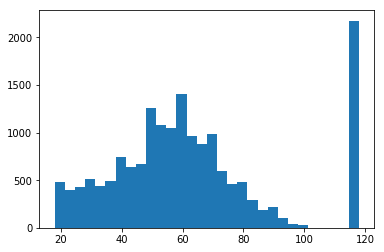

In [7]:
# A quick glimps on data distribution
plt.hist(profile['age'], bins=30)
print('Age distribution')

In [8]:
# Deep check of possible value from profiles with age equal to 118 years.
gender118 = str(profile['gender'][profile['age'] == 118].unique())
income118 = str(profile['income'][profile['age'] == 118].unique())
total = str(profile['age'][profile['age'] == 118].shape[0])

print('Since accounts with age 118 have {} gender and {} income, I decided to drop this {} accounts'.format(gender118, income118, total))

Since accounts with age 118 have [None] gender and [nan] income, I decided to drop this 2175 accounts


In [9]:
# Drop rows with age 118
profile = profile.drop(profile[profile['age']==118].index,axis=0)

In [10]:
# Rename id to cust_id in order to easily join it with transcript data set
profile = profile.rename(columns={'id':'cust_id'})

In [11]:
#Change format of the date
profile.became_member_on=pd.to_datetime(profile.became_member_on, format='%Y%m%d')
profile.head()

,gender,age,cust_id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0


In [12]:
# Extract year in distinct column from "became_member_on"
profile["became_member_on"] = pd.to_datetime(profile["became_member_on"])
profile["became_member_year"] = profile['became_member_on'].dt.strftime("%Y")

### Transcript transformation

In [13]:
print(transcript.shape)
transcript.head(10)

(306534, 4)


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
6,c4863c7985cf408faee930f111475da3,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
9,31dda685af34476cad5bc968bdb01c53,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


In [14]:
# extract values from 'value' column
value_columns = pd.json_normalize(transcript['value'])
# 'reward' also presented in portfolio, so it can be dropped here
value_columns = value_columns.drop(['reward'], axis=1)
# in the data set 'offer id' parameter presented in two columns, which I need to merge:
value_columns['offer_id'] = value_columns['offer_id'].fillna(value_columns['offer id'])
value_columns = value_columns.drop(['offer id'], axis=1)

In [15]:
# Rename person to cust_id for easy join
transcript = transcript.rename(columns={'person':'cust_id'})
# since I extracted values from 'value' to separate columns, I can drop it
transcript = transcript.drop(['value'], axis=1)
# join columns extracted from value column
transcript = pd.concat([transcript, value_columns], axis=1)
transcript

,cust_id,event,time,amount,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0
...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,1.59,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,9.53,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,714,3.61,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,3.53,NaN


In [16]:
# Convert "event" to 1/0
dummies = pd.get_dummies(transcript.event)
transcript = pd.concat([transcript,dummies],axis=1)
transcript.head()

,cust_id,event,time,amount,offer_id,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,0,1,0,0


## Merge all datasets for analysis

In [17]:
# Merge the three dataframes 
df = profile.merge(transcript,how='left',on='cust_id')
df = df.merge(portfolio,how='left',on='offer_id')
df.head()

,gender,age,cust_id,became_member_on,income,became_member_year,event,time,amount,offer_id,...,difficulty,duration,offer_type,web,email,mobile,social,bogo,discount,informational
0,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,transaction,18,21.51,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,transaction,144,32.28,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,offer received,408,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,...,5.0,7.0,bogo,1.0,1.0,1.0,0.0,1.0,0.0,0.0
3,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,offer received,504,NaN,3f207df678b143eea3cee63160fa8bed,...,0.0,4.0,informational,1.0,1.0,1.0,0.0,0.0,0.0,1.0
4,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,transaction,528,23.22,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
# Save as pickle to save time
df.to_pickle("data/merged_df.pkl")
portfolio.to_pickle("data/portfolio.pkl")
profile.to_pickle("data/profile.pkl")
transcript.to_pickle("data/transcript.pkl")

## Start analysis

In [19]:
# Import libraries to start from here
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import svm
from sklearn import metrics
from sklearn import preprocessing
% matplotlib inline

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [20]:
# Read pickle
df = pd.read_pickle("data/merged_df.pkl")
portfolio = pd.read_pickle("data/portfolio.pkl")
profile = pd.read_pickle("data/profile.pkl")
transcript = pd.read_pickle("data/transcript.pkl")

### Portfolio data

This data consists of the definition of the offers, like the difficulty or the reward for completing them.

In [21]:
portfolio

,reward,difficulty,duration,offer_type,offer_id,web,email,mobile,social,bogo,discount,informational
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1,1,0,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0,0,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,1,0,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0,0,1,0
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,0,0,1
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,1,0,0,1,0


#### Q: How many different offers exist and what are the proportions of the offer types?

In [22]:
portfolio_n = portfolio.shape[0]
portfolio_bogo = portfolio[portfolio['offer_type']=='bogo'].count()['offer_type']/portfolio_n*100
portfolio_discount = portfolio[portfolio['offer_type']=='discount'].count()['offer_type']/portfolio_n*100
portfolio_informational = portfolio[portfolio['offer_type']=='informational'].count()['offer_type']/portfolio_n*100

print("In the data set presented {} different offers with the following distribution: \n Bogo - {}% \n Discount - {}% \n Informational - {}%".format(portfolio_n, portfolio_bogo, portfolio_discount, portfolio_informational))

In the data set presented 10 different offers with the following distribution: 
 Bogo - 40.0% 
 Discount - 40.0% 
 Informational - 20.0%


### Profile

The profile data consists of demographic data about the customers.

In [23]:
profile.head()

,gender,age,cust_id,became_member_on,income,became_member_year
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,2018
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,2018
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,2017


#### Q: How old are the members?

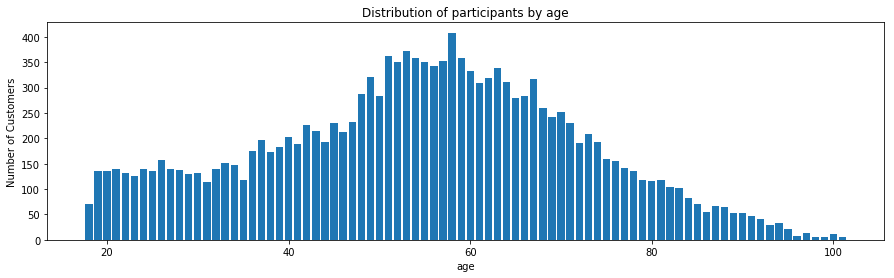

Mean:  54
Median:  55
Mode:  58

This barchart shows that the most customers are between 50 and 70 years old. The mean of the age lies at 54 years The most present age is 58 years 50 % of the customers are younger than 55 years.


In [24]:
fig = plt.figure(figsize=(15,4))

plt.bar(list(set(profile["age"].unique())), profile["age"].value_counts().sort_index())
plt.title('Distribution of participants by age')
plt.ylabel('Number of Customers')
plt.xlabel("age")

plt.show()
print("Mean: ", int(profile["age"].mean()))
print("Median: ", int(profile["age"].median()))
print("Mode: ", int(profile["age"].mode()))

print("\nThis barchart shows that the most customers are between 50 and 70 years old. The mean of the age lies at 54 years The most present age is 58 years 50 % of the customers are younger than 55 years.")

##### Q: What is the gender diversity among members?

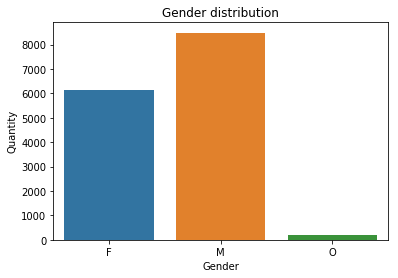

The gender distribution is following: 
     Males:  57.23  %
   Females: 41.34 %
     Other: 1.43 %


In [25]:
sns.countplot(x='gender',data=profile)
plt.title('Gender distribution')
plt.ylabel('Quantity')
plt.xlabel('Gender')

profile_n = profile.shape[0]
plt.show()
print("The gender distribution is following: \n\
     Males: ", round(profile[profile['gender']=='M'].count()['gender']/profile_n*100,2), " %")
print("   Females: "+str(round(profile[profile['gender']=='F'].count()['gender']/profile_n*100,2))+" %")
print("     Other: "+str(round(profile[profile['gender']=='O'].count()['gender']/profile_n*100,2))+" %")

##### Q: Which income do they have?

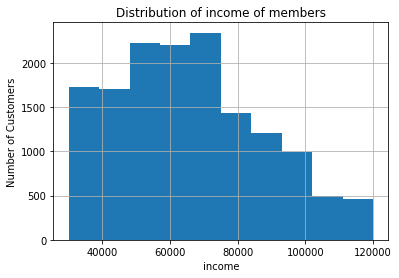

Min:  30000
Max:  120000
Mean:  65404
Median:  64000
Mode:  73000

This histogram shows that customers income varies between $30K-120K with the most common income $73K. Not many customers have salary above this treshold and about 50% have salary less than $64K


In [26]:
profile['income'].hist()
plt.title('Distribution of income of members')
plt.ylabel('Number of Customers')
plt.xlabel("income")

plt.show()
print("Min: ", int(profile["income"].min()))
print("Max: ", int(profile["income"].max()))
print("Mean: ", int(profile["income"].mean()))
print("Median: ", int(profile["income"].median()))
print("Mode: ", int(profile["income"].mode()))

print("\nThis histogram shows that customers income varies between $30K-120K with the most common income $73K. \
Not many customers have salary above this treshold and about 50% have salary less than $64K")

##### Q: When customers got memberships?

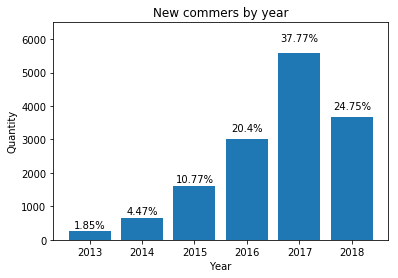

In [27]:
year, count = np.unique(profile["became_member_year"], return_counts=True)

fig, ax = plt.subplots()

bar_plot = plt.bar(year, count)
plt.title('New commers by year')
plt.ylabel('Quantity')
plt.ylim(0,6500)
plt.xlabel("Year")

# Add percentages to the plot
def autolabel(rects):
    for idx,rect in enumerate(bar_plot):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                 str(round(profile[profile["became_member_year"]==year[idx]].count()['became_member_year']/profile_n*100,2))+"%", ha='center', va='bottom', rotation=0)

autolabel(bar_plot)

The quantity of new commers are increasing with mobile internet popularity. As we can see, the peak was on 2017, but after, it is decreasing mostly because all who want to join already joined. 

The outcome could be that 75% of our customers with us more than 2 years (today 2019).

##### Q: How is the distribution of the age between the genders

Text(0.5,1,'Age distribution between genders')

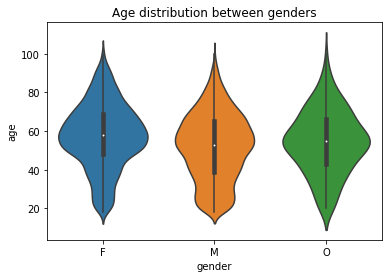

In [28]:
sns.violinplot(x="gender", y="age", data=profile).set_title("Age distribution between genders")

It shows that men early start interest to app than women. But middle age women have more interest then men.

### Transcript data

In [29]:
transcript.head()

,cust_id,event,time,amount,offer_id,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,0,1,0,0


##### Q: How is the distribution of the different events?

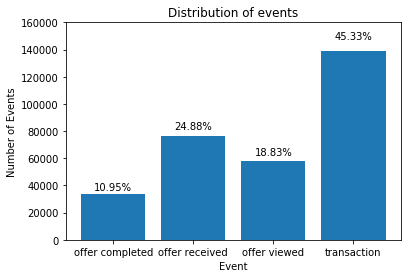

In [30]:
transcript_n = transcript['event'].count()
year, count = np.unique(transcript['event'], return_counts=True)

fig, ax = plt.subplots()

bar_plot = plt.bar(year, count)
plt.title('Distribution of events')
plt.ylabel('Number of Events')
plt.ylim(0,160000)
plt.xlabel("Event")

# Add percentages for the plot
def autolabel(rects):
    for idx,rect in enumerate(bar_plot):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                 str(round(transcript[transcript['event']==year[idx]].count()['event']/transcript_n*100,2))+"%", ha='center', va='bottom', rotation=0)

autolabel(bar_plot)

It shows that at least half of transactions processed without offers.

75% of offers viewed by customers, and 55% of the viewed offers were completed.

### Offer Data

In [31]:
# Split offers from transaction
offer_df = df[df["event"] != "transaction"]
transaction_df = df[df["event"] == "transaction"]
offer_df.head()

,gender,age,cust_id,became_member_on,income,became_member_year,event,time,amount,offer_id,...,difficulty,duration,offer_type,web,email,mobile,social,bogo,discount,informational
2,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,offer received,408,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,...,5.0,7.0,bogo,1.0,1.0,1.0,0.0,1.0,0.0,0.0
3,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,offer received,504,NaN,3f207df678b143eea3cee63160fa8bed,...,0.0,4.0,informational,1.0,1.0,1.0,0.0,0.0,0.0,1.0
5,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,offer completed,528,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,...,5.0,7.0,bogo,1.0,1.0,1.0,0.0,1.0,0.0,0.0
6,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,...,5.0,7.0,bogo,1.0,1.0,1.0,0.0,1.0,0.0,0.0
7,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,offer viewed,6,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,...,5.0,7.0,bogo,1.0,1.0,1.0,0.0,1.0,0.0,0.0


In [32]:
# Separate data to chunks
income_group_names = list(["0-40k", "40k-60k", "60k-80k", "80k-100k", "100k-120k"])
income_group_values = list([0, 40000, 60000, 80000, 100000, 120000])
offer_df['income_group'] = np.nan
i = 0
for group in income_group_names:
    offer_df['income_group'][(offer_df['income'] >= income_group_values[i]) & (offer_df['income'] <= income_group_values[int(i+1)])] = group
    i+=1
    if i == 5:
        offer_df['income_group'][(offer_df['income'] > income_group_values[i])] = group
        break

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:1021: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

In [33]:
# Separate data to chunks
age_group_names = list(["18-30", "30-40", "40-50", "50-60", "60-70", "70-80", "80-90"])
age_group_values = list([0, 30, 40, 50, 60, 70, 80, 90])
offer_df['age_group'] = np.nan
i = 0
for group in age_group_names:
    offer_df['age_group'][(offer_df['age'] >= age_group_values[i]) & (offer_df['age'] <= age_group_values[int(i+1)])] = group
    i+=1
    if i == 5:
        offer_df['age_group'][(offer_df['age'] > age_group_values[i])] = group
        break

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:1021: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

In [34]:
offer_df

,gender,age,cust_id,became_member_on,income,became_member_year,event,time,amount,offer_id,...,offer_type,web,email,mobile,social,bogo,discount,informational,income_group,age_group
2,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,offer received,408,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,...,bogo,1.0,1.0,1.0,0.0,1.0,0.0,0.0,100k-120k,50-60
3,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,offer received,504,NaN,3f207df678b143eea3cee63160fa8bed,...,informational,1.0,1.0,1.0,0.0,0.0,0.0,1.0,100k-120k,50-60
5,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,offer completed,528,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,...,bogo,1.0,1.0,1.0,0.0,1.0,0.0,0.0,100k-120k,50-60
6,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,...,bogo,1.0,1.0,1.0,0.0,1.0,0.0,0.0,100k-120k,60-70
7,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,offer viewed,6,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,...,bogo,1.0,1.0,1.0,0.0,1.0,0.0,0.0,100k-120k,60-70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272754,F,62,e4052622e5ba45a8b96b59aba68cf068,2017-07-22,82000.0,2017,offer received,336,NaN,3f207df678b143eea3cee63160fa8bed,...,informational,1.0,1.0,1.0,0.0,0.0,0.0,1.0,80k-100k,60-70
272755,F,62,e4052622e5ba45a8b96b59aba68cf068,2017-07-22,82000.0,2017,offer received,408,NaN,f19421c1d4aa40978ebb69ca19b0e20d,...,bogo,1.0,1.0,1.0,1.0,1.0,0.0,0.0,80k-100k,60-70
272757,F,62,e4052622e5ba45a8b96b59aba68cf068,2017-07-22,82000.0,2017,offer completed,480,NaN,f19421c1d4aa40978ebb69ca19b0e20d,...,bogo,1.0,1.0,1.0,1.0,1.0,0.0,0.0,80k-100k,60-70
272759,F,62,e4052622e5ba45a8b96b59aba68cf068,2017-07-22,82000.0,2017,offer viewed,546,NaN,f19421c1d4aa40978ebb69ca19b0e20d,...,bogo,1.0,1.0,1.0,1.0,1.0,0.0,0.0,80k-100k,60-70


##### Q: What are the general satistics of customers?

In [35]:
q_customers = offer_df.groupby('cust_id').count()
    
print("Customers quantity: ", q_customers.shape[0])
print("Offers quantity: ", offer_df.shape[0])

Customers quantity:  14820
Offers quantity:  148805


##### Q: Does the membership period affect the completion of offers?

In [36]:
membership_to_offer = offer_df.groupby(['became_member_year']).sum()[['offer completed', 'offer viewed', 'offer received']]
membership_to_offer['offer completed'] = membership_to_offer['offer completed'] / membership_to_offer['offer received'] * 100
membership_to_offer['offer viewed'] = (membership_to_offer['offer viewed'] / membership_to_offer['offer received'] * 100) - membership_to_offer['offer completed']
membership_to_offer['offer received'] = 100 - membership_to_offer['offer completed'] - membership_to_offer['offer viewed']
membership_to_offer

,offer completed,offer viewed,offer received
became_member_year,,,
2013,45.758564,28.711256,25.530179
2014,44.433232,31.550622,24.016145
2015,60.405594,14.783217,24.811189
2016,66.035503,10.288462,23.676036
2017,48.234826,26.666667,25.098507
2018,31.477555,42.272975,26.249470


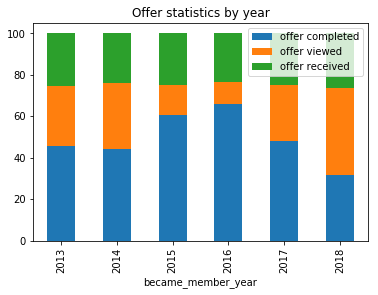

In [37]:
# plot a Stacked Bar Chart using matplotlib
membership_to_offer.plot.bar(
    stacked = True,
    title = 'Offer statistics by year',
    mark_right = True)

The rate received/viewed offers is stable across all time. Offer viewed/completed varies by year.

Members who joined in 2015-2016 have the highest rate of offer complition, while new commers 2017-2018 completed less offers.

##### Q: Does offer completion depends on gender?

Text(0.5,1,'Distribution of offer statuses between genders')

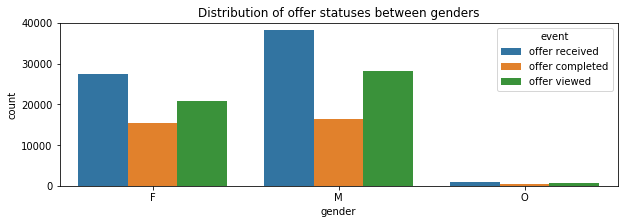

In [38]:
#Set up a figure
fig = plt.figure(figsize=(10,3))
sns.countplot(x="gender", hue="event", data=offer_df).set_title("Distribution of offer statuses between genders")

This diagram shows that gender does not affect rate received/viewed offers, but females more often complete offers than mans.

##### Q: How does the age influence the completion of offers?

Text(0.5,1,'Distribution of events in different age groups')

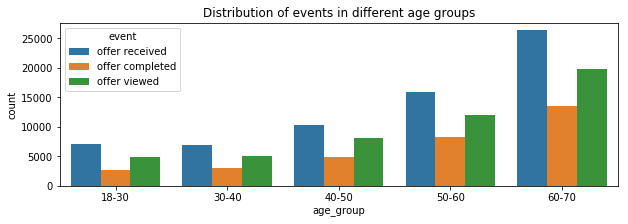

In [39]:
#Set up a figure
fig = plt.figure(figsize=(10,3))
sns.countplot(order=sorted(offer_df['age_group'].unique()),x="age_group", hue="event", data=offer_df).set_title("Distribution of events in different age groups")

In general, age does not significantly affect the rate.

##### Q: How does the income influence the completion of an offer?

Text(0.5,1,'Distribution of events in different income groups')

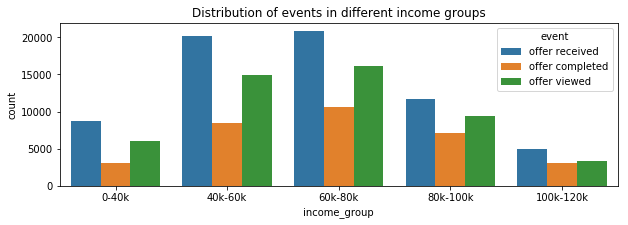

In [40]:
#Set up a figure
fig = plt.figure(figsize=(10,3))
sns.countplot(order=["0-40k", "40k-60k", "60k-80k", "80k-100k", "100k-120k"],x="income_group", hue="event", data=offer_df).set_title("Distribution of events in different income groups")

Low income groups complete less offers than higher income groups.

The best completion rate is in income ranges from 80,000 to 120,000 USD

### Conclusion
For getting an overall good response for offers I would recommend to give offers to female members older than 50 years, who are longer a part of the starbucks community. The income should be higher than 70,000 USD a year. For the offer type I think it does not matter if it is the bogo or the discount offer but the discount offer is completed slightly better than the bogo offer.

## Modeling
We will predict if offer will be completed by customer.

In [41]:
offer_df.head()

,gender,age,cust_id,became_member_on,income,became_member_year,event,time,amount,offer_id,...,offer_type,web,email,mobile,social,bogo,discount,informational,income_group,age_group
2,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,offer received,408,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,...,bogo,1.0,1.0,1.0,0.0,1.0,0.0,0.0,100k-120k,50-60
3,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,offer received,504,NaN,3f207df678b143eea3cee63160fa8bed,...,informational,1.0,1.0,1.0,0.0,0.0,0.0,1.0,100k-120k,50-60
5,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,2017,offer completed,528,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,...,bogo,1.0,1.0,1.0,0.0,1.0,0.0,0.0,100k-120k,50-60
6,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,...,bogo,1.0,1.0,1.0,0.0,1.0,0.0,0.0,100k-120k,60-70
7,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,2017,offer viewed,6,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,...,bogo,1.0,1.0,1.0,0.0,1.0,0.0,0.0,100k-120k,60-70


In [42]:
# select columns for modeling
df_model = offer_df[['cust_id','offer_id','offer viewed','offer completed','gender','became_member_year','duration','difficulty','reward','bogo', 'discount', 'informational', 'email', 'mobile', 'social', 'web',
       'income_group', 'age_group']]

#Group subset of offer by customer_id and offer_id with the max() function to get the values of the event into one row for further processing, if the offer was viewed and then completed.
df_model = df_model.groupby(['cust_id','offer_id']).max().reset_index()

#Assign the 1 for a viewed and completed offer
df_model.loc[(df_model['offer viewed'] == 1) & (df_model['offer completed'] == 1) , 'offer_viewed_completed'] = 1 


#Fill the resulting NaN values with a 0  for not meeting the this condition 
df_model['offer_viewed_completed'] = df_model['offer_viewed_completed'].fillna(0)

#Create dummies of age and income clusters for ML
age_dummies = pd.get_dummies(df_model['age_group'], prefix='age')
df_model = pd.concat([df_model,age_dummies],axis=1)

income_dummies = pd.get_dummies(df_model['income_group'], prefix='income')
df_model = pd.concat([df_model,income_dummies],axis=1)

membership_dummies = pd.get_dummies(df_model['became_member_year'], prefix='became_member_year')
df_model = pd.concat([df_model,membership_dummies],axis=1)

gender_dummies = pd.get_dummies(df_model['gender'], prefix='gender')
df_model = pd.concat([df_model,gender_dummies],axis=1)

# Delete variables, only use dummies
df_model = df_model.drop(['cust_id','offer_id','offer viewed','offer completed','age_group','income_group','became_member_year','gender'],axis=1)
    
df_model.head()

,duration,difficulty,reward,bogo,discount,informational,email,mobile,social,web,...,income_80k-100k,became_member_year_2013,became_member_year_2014,became_member_year_2015,became_member_year_2016,became_member_year_2017,became_member_year_2018,gender_F,gender_M,gender_O
0,7.0,10.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,0,0,0,0,0,1,0,0,1,0
1,4.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,...,0,0,0,0,0,1,0,0,1,0
2,3.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0,0,0,0,0,1,0,0,1,0
3,5.0,5.0,5.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,1,0,0,1,0
4,10.0,10.0,2.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,1,0,0,1,0


In [43]:
# Split model into target and variables 
X = df_model.drop('offer_viewed_completed',axis=1)
y = df_model['offer_viewed_completed']

# Create test and train data sets
X_train, X_test, y_train,y_test = train_test_split(X, y, test_size=0.25)

In [44]:
# ML with RandomForestClassifer using different parameters
clf = RandomForestClassifier(random_state=0)
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)
print(accuracy_score(y_test.values,prediction))

clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)
print(accuracy_score(y_test.values,prediction))

clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)
print(accuracy_score(y_test.values,prediction))

0.751412429378531
0.7574243082717659
0.7591626828914965


A maximum depth of 10 and a number of estimators of 100 is the perfect parameter set for this prediction